Hi,as we are known that Yolo v5 is out of the competition.But V5 did work.As the [discussion](https://www.kaggle.com/search) mention:

    First --> It is doing gradient accumulation by default to a batch size of 64
    second --> It is also giving mixed precision training(fp16) by default if we have apex installed
    
    
So let change it to EfficientDet.May be work :))  Hope the notebook will be helpful for someone. please feel free to upvote

This notebook is base on the [Alex's job](https://www.kaggle.com/shonenkov/training-efficientdet)

In [1]:
#!pip install --upgrade pip

In [2]:
#!pip install --no-deps '../input/timm-package/timm-0.1.26-py3-none-any.whl' > /dev/null
#!pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null
#!kaggle kernels pull reighns/augmentations-data-cleaning-and-bounding-boxes https://www.kaggle.com/reighns/augmentations-data-cleaning-and-bounding-boxes
#!kaggle kernels pull ravi02516/cleaning-and-preprocessing-train-csv https://www.kaggle.com/ravi02516/cleaning-and-preprocessing-train-csv
#!kaggle kernels pull raininbox/check-clean-big-small-bboxes https://www.kaggle.com/raininbox/check-clean-big-small-bboxes
#!wget https://github.com/DhruvMakwana/Global-Wheat-Detection/blob/master/Global_Wheat_Detection_EDA.ipynb
#!wget https://github.com/Kaushal28/Global-Wheat-Detection/blob/master/EfficientDet-5-fold-CV/gwd-efficientdet-training-fold4.ipynb

#!kaggle datasets download -d shonenkov/omegaconf
#!kaggle datasets download -d kaushal2896/pycocotools
#!wget https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_d5-ef44aea8.pth
#!pip install kaggle --force
#!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!kaggle competitions download -c global-wheat-detection -p ./data/
#!mkdir ./data/
#!mkdir ./data/train_images
#!git clone https://github.com/NVIDIA/apex
#!pip install -v --no-cache-dir  ./apex
#!mv *.jpg ./data/train_images
#import os
#!unzip -q ./data/global-wheat-detection.zip -d  ./data/
#!cp *.csv ./data/
#!pip install albumentations --force
#!pip install timm
#!pip install effdet

In [3]:
#!kaggle datasets download -d shonenkov/timm-efficientdet-pytorch
#!pip install effdet
#!pip install omegaconf
#!kaggle competitions download -c global-wheat-detection -p ./data/
#!mkdir ./data/
#!mkdir ./data/train_images
#!mv *.jpg ./data/train_images
#import os
#!unzip -q ./data/global-wheat-detection.zip -d  ./data/
#!cp train_clean.csv ./data/
#len(os.listdir('./data/train_images'))
#!pip install kaggle --force
#!pip install omegaconf
#%%writefile setup.sh

'/kaggle/input'

'/kaggle/input'

In [4]:
apex_on =  True
if apex_on:
    #! pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ../input/nvidiaapex/.
    ! pip install  --no-cache-dir ../input/nvidia-apex/ 
#if apex_on:
#    from apex import amp

!pip install --no-deps '../input/timm-package/timm-0.1.26-py3-none-any.whl' > /dev/null
!pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null

Processing /kaggle/input/nvidia-apex
  Created wheel for apex: filename=apex-0.1-py3-none-any.whl size=137240 sha256=a5d74922af1528ad6197e1e404f250686625614ef737e4f77d660772041c781d
  Stored in directory: /tmp/pip-ephem-wheel-cache-oidk3ld_/wheels/12/d5/e9/8ae7d334b0f3b85522d2d23e92ea0712f8bde7343e59a5dcbf
Successfully built apex
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [5]:
!pip install --no-deps '../input/timm-package/timm-0.1.26-py3-none-any.whl' > /dev/null
!pip install --no-deps '../input/pycocotools/pycocotools-2.0-cp37-cp37m-linux_x86_64.whl' > /dev/null

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [6]:
import sys
sys.path.insert(0, "../input/timm-efficientdet-pytorch")
sys.path.insert(0, "../input/omegaconf")
sys.path.insert(0, "../input/timm")
from apex import amp
import torch
import os
from datetime import datetime
import time
import random
import cv2
import pandas as pd
import numpy as np
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch  import ToTensorV2

from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from glob import glob
#from apex import amp
SEED = 49

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(SEED)

1. mixed_precision:True = using the apex
2. accumulate: how many batches to make the gradient accumulation e.g batch_size = 2 & accumulate = 16 -> real batch is 2*16 =32

In [7]:
class TrainGlobalConfig:
    num_workers = 10
    batch_size = 14
    n_epochs = 8 # n_epochs = 40
    lr =2e-4
    mixed_precision = True
    accumulate = 4
    folder = 'effdet5-cutmix'

    # -------------------
    verbose = True
    verbose_step = 1
    # -------------------

    # --------------------
    step_scheduler = False  # do scheduler.step after optimizer.step
    validation_scheduler = True  # do scheduler.step after validation stage loss

    #     SchedulerClass = torch.optim.lr_scheduler.OneCycleLR
    #     scheduler_params = dict(
    #         max_lr=0.001,
    #         epochs=n_epochs,
    #         steps_per_epoch=int(len(train_dataset) / batch_size),
    #         pct_start=0.1,
    #         anneal_strategy='cos',
    #         final_div_factor=10**5
    #     )

    SchedulerClass = torch.optim.lr_scheduler.ReduceLROnPlateau
    scheduler_params = dict(
        mode='min',
        factor=0.5,
        patience=2,
        verbose=False,
        threshold=0.0001,
        threshold_mode='abs',
        cooldown=0,
        min_lr=1e-8,
        eps=1e-08
    )
print('x')

x


In [8]:
clean='Y'
if clean=='Y':
    
    #marking = pd.read_csv('/data/modified_cleaned_data.csv')
    marking = pd.read_csv('/kaggle/input/clean-data/modified_cleaned_data.csv')
    marking.drop(columns=['bbox'], inplace=True)
    marking.columns=['image_id', 'width', 'height', 'source', 'area', 'x','y', 'w', 'h']
else:
    marking = pd.read_csv('../input/global-wheat-detection/train.csv')
#pd.read_csv('train.csv')
#('../input/global-wheat-detection/train.csv')

    bboxs = np.stack(marking['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
    for i, column in enumerate(['x', 'y', 'w', 'h']):
        marking[column] = bboxs[:,i]
    marking.drop(columns=['bbox'], inplace=True)

In [9]:
#bad_boxes = [3687, 117344,173,113947,52868,2159,2169,121633,121634,147504,118211,52727,147552]
marking.image_id.unique()

array(['f46fea3a3', 'c09caecc1', 'e87d43a13', ..., '41457a646',
       'ce4124be0', 'b1356efe7'], dtype=object)

In [10]:
'''
x_tot=[]
x2_tot=[]
unique_list=marking.image_id.unique().tolist()
from  tqdm import tqdm_notebook as tqdm
from PIL import Image as PILImage
for name in  tqdm(unique_list) :
    #print(os.path.join(data_dir,name+'.tiff'))
    #img = skimage.io.MultiImage(os.path.join(data_dir,name+'.tiff'))[-2]
                 
    #img=Image.open(save_dir + img_id+'_'+str(index)+'.png')
    #mask = skimage.io.MultiImage(os.path.join(MASKS,name+'_mask.tiff'))[-1]
    #print(name)
    #img_cnt=slice_cnt_df[slice_cnt_df.image_id==name].count_img.values[0]  
    #print(img_cnt,name)
    tiles = PILImage.open('../input/global-wheat-detection/train' +'/'+ name+ '.jpg') 
              
    img=np.asarray(tiles)
    x_tot.append((img/255.0).reshape(-1,3).mean(0))#channel wise for each 20 tiles
    x2_tot.append(((img/255.0)**2).reshape(-1,3).mean(0)) 
     
''' 

"\nx_tot=[]\nx2_tot=[]\nunique_list=marking.image_id.unique().tolist()\nfrom  tqdm import tqdm_notebook as tqdm\nfrom PIL import Image as PILImage\nfor name in  tqdm(unique_list) :\n    #print(os.path.join(data_dir,name+'.tiff'))\n    #img = skimage.io.MultiImage(os.path.join(data_dir,name+'.tiff'))[-2]\n                 \n    #img=Image.open(save_dir + img_id+'_'+str(index)+'.png')\n    #mask = skimage.io.MultiImage(os.path.join(MASKS,name+'_mask.tiff'))[-1]\n    #print(name)\n    #img_cnt=slice_cnt_df[slice_cnt_df.image_id==name].count_img.values[0]  \n    #print(img_cnt,name)\n    tiles = PILImage.open('../input/global-wheat-detection/train' +'/'+ name+ '.jpg') \n              \n    img=np.asarray(tiles)\n    x_tot.append((img/255.0).reshape(-1,3).mean(0))#channel wise for each 20 tiles\n    x2_tot.append(((img/255.0)**2).reshape(-1,3).mean(0)) \n     \n"

In [11]:
#img_avr =  np.array(x_tot).mean(0)
#img_std =  np.sqrt(np.array(x2_tot).mean(0) - img_avr**2) #456 stats
#print('mean:',img_avr, ', std:', np.sqrt(img_std))

#(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225) 
#mean: [0.31463625 0.31740943 0.21443922] , std: [0.49570253 0.48870521 0.44089793]

About data splitting you can read [here](https://www.kaggle.com/shonenkov/wbf-approach-for-ensemble):

In [12]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

df_folds = marking[['image_id']].copy()

df_folds.loc[:, 'bbox_count'] = 1
 
df_folds = df_folds.groupby('image_id').count()
df_folds.loc[:, 'source'] = marking[['image_id', 'source']].groupby('image_id').min()['source']
df_folds.loc[:, 'stratify_group'] = np.char.add(
    df_folds['source'].values.astype(str),
    df_folds['bbox_count'].apply(lambda x: f'_{x // 15}').values.astype(str)
)
df_folds=df_folds.reset_index(level=0)
#df_folds=df_folds[(df_folds.bbox_count<60)] #take subset
df_folds.loc[:, 'fold'] = 0

for fold_number, (train_index, val_index) in enumerate(skf.split(X=df_folds.index, y=df_folds['stratify_group'])):
    df_folds.loc[df_folds.iloc[val_index].index, 'fold'] = fold_number

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


In [13]:


#train_image_ids=df_folds[df_folds!=0].image_id.values.tolist() #train images
#index.train_image_ids=df_folds[(df_folds!=0)&(df_folds<40)].image_id.values.tolist() #train images
df_folds.index.size

3373

In [14]:
#df_folds.index.size

In [15]:
TRAIN_ROOT_PATH ='../input/global-wheat-detection/train'
from PIL import Image as PILImage, ImageDraw, ImageEnhance
from collections import OrderedDict 
def group_boxes(group):
    #print(group)
    boundaries = group['bbox'].str.split(',', expand=True)
    #print(boundaries.shape)
    boundaries[0] = boundaries[0].str.slice(start=1)
    boundaries[3] = boundaries[3].str.slice(stop=-1)
    
    return boundaries.values.astype(float)

def load_image(image_id):
    image = PILImage.open('TRAIN_ROOT_PATH/' + image_id + ".jpg")
    #image = image.resize((256, 256))
    
    return np.asarray(image)

def draw_bboxes(image_id, bboxes, source='./data/train'):   #'./data/train'
    #image = PILImage.open('../input/global-wheat-detection/' + source +'/' + image_id + ".jpg")
    image = PILImage.open(    TRAIN_ROOT_PATH +'/' + image_id + ".jpg")
    #image = image.resize((256,256))
    
    draw = ImageDraw.Draw(image)
            
    for bbox in bboxes:
        draw_bbox(draw, bbox)
    
    return np.asarray(image)
import cv2

def draw_bbox(draw, bbox):
    x, y, width, height = bbox
    draw.rectangle([x, y, x + width, y + height], width=10, outline='red')
def show_images(image_ids, bboxes, source='train'):
    pixels = []
    i=0
    for image_id in image_ids:
        if i==0:
            
            #bboxes_list=np.stack(marking[marking.image_id==image_id]['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))
            bboxes_list=[np.array(bboxes_list)  for bboxes_list in bboxes]
            print(bboxes_list)
        else:
            #bboxes_list=bboxes[image_id]
            bboxes_list=[np.array(bboxes_list)  for bboxes_list in bboxes]
            print(bboxes_list)
        i=i+1
        pixels.append(
            draw_bboxes(image_id, bboxes_list, source)
        )
    
    num_of_images = len(image_ids)
    print(num_of_images)
    fig, axes = plt.subplots(
        1, 
        num_of_images, 
        figsize=(5 * 4, 5 * 4)
    )
    
    for i, image_pixels in enumerate(pixels):
        axes[0].imshow(image_pixels)
        image = cv2.imread(    TRAIN_ROOT_PATH +'/' + image_id + ".jpg")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)#.astype(np.float32)
        print(image.shape)
        #aug=A.IAAEmboss  (p=1)
        #aug1=A.OneOf([A.IAAEmboss  (p=0.0),A.CLAHE((1.5,4),p=0.8),A.IAASharpen(p=0.4)],p=1)
        aug1=A.Compose([A.CLAHE((1.5,4),p=0.7),A.IAAEmboss  (p=0.0),A.IAASharpen(p=0.4)],p=0.8)
        #aug=A.Compose([aug1,A.CLAHE((1.5,4),p=1)],p=1)
        #aug= A.RandomContrast( limit=(0.2,0.4),p=1) 
        #aug= A.RandomBrightness( limit=(0.2,0.4),p=1) 
        #aug=A.RandomBrightnessContrast(brightness_limit=(0.2,0.3), 
        #                                   contrast_limit=(0.2,0.4), p=1)
        #aug=A.CLAHE((1.5,4),p=1)
        #                                   contrast_limit=0.0, p=1)
        #aug=A.HueSaturationValue(hue_shift_limit=(0.1,0.25), sat_shift_limit= (0.1,0.25), 
        #                             val_shift_limit=(0.1,0.25), p=1)
        #A.imgaug.transforms.IAAPerspective((0.08,0.15),p=1)
        #aug=A.OneOf([A.IAAEmboss  (p=0.4),A.IAASharpen(p=0.4)],p=1)
        #print(aug(image=image).shape)
        axes[1].imshow(aug1(image=image)['image'])
        
        
        


In [16]:
records =marking[marking['image_id'] == '50ee1a4fc']
bboxes = records[['x', 'y', 'w', 'h']].values

In [17]:
bboxes=np.array([[29.5,  0. , 76. , 67. ],[192.  ,  0.,  225.5 , 53.5],[229.  ,  0. , 275. ,  61.5]])


In [18]:
#show_images(['50ee1a4fc','50ee1a4fc'],bboxes)

In [19]:
'''
labels = pd.read_csv('train.csv')
labels = labels.groupby('image_id').apply(group_boxes)
train_pixels = OrderedDict() 
train_labels = OrderedDict() 
from tqdm import tqdm
for image_id in tqdm(train_image_ids):
    train_pixels[image_id] = load_image(image_id)
    train_labels[image_id] = labels[image_id].copy() # / 4
'''

"\nlabels = pd.read_csv('train.csv')\nlabels = labels.groupby('image_id').apply(group_boxes)\ntrain_pixels = OrderedDict() \ntrain_labels = OrderedDict() \nfrom tqdm import tqdm\nfor image_id in tqdm(train_image_ids):\n    train_pixels[image_id] = load_image(image_id)\n    train_labels[image_id] = labels[image_id].copy() # / 4\n"

In [20]:
def clean_labels(train_image_ids, train_labels):
    good_labels = {}
    
    for i, image_id in enumerate(train_image_ids):
        good_labels[image_id] = []
        
        for j, label in enumerate(train_labels[image_id]):

            # remove huge bbox
            if label[2] * label[3] > 8000 and i not in [1079, 1371, 2020]:
                continue

            # remove tiny bbox
            elif label[2] < 5 or label[3] < 5:
                continue
                
            else:
                good_labels[image_id].append(
                    train_labels[image_id][j]
                )
                
    return good_labels

#train_labels_cln = clean_labels(train_image_ids, train_labels)

In [21]:
#np.array(train_labels_cln['b6ab77fd7']).shape ,marking.head()
records =marking[marking['image_id'] == '005b0d8bb']
boxes = records[['x', 'y', 'w', 'h']].values
boxes.shape

(20, 4)

In [22]:
#show_images(['005b0d8bb','005b0d8bb'], boxes, source='./data/train')#

In [23]:
#transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]
boxes[:,2] =np.clip(boxes[:,0]+boxes[:,2],0,1024-1)
boxes[:,2]

array([  81.,  223.,  951.,   72., 1023.,   81.,  881.,  931.,  849.,
        406.,  237., 1022.,  756.,  396.,  860.,  525.,  377.,  773.,
        454.,  475.])

## Albumentations

In [24]:
def get_train_transforms():
    return A.Compose(
        [
            A.RandomSizedCrop(min_max_height=(800, 800), height=1024, width=1024, p=0.5),
            #A.RandomCrop(768, 768, always_apply=False, p=0.5),#New
            A.OneOf([
                A.HueSaturationValue(hue_shift_limit=(0.1,0.2), sat_shift_limit= (0.1,0.2), 
                                     val_shift_limit=(0.1,0.2), p=0.8), #0.9
                A.RandomBrightnessContrast(brightness_limit=(0.1,0.2), 
                                           contrast_limit=(0.1,0.3), p=0.8), #0.9
            ],p=0.9),
            #A.RandomSunFlare(p=0.4,num_flare_circles_lower=4, num_flare_circles_upper=8, src_radius=300),#new
            #A.CLAHE(p=0.9),#New
            A.RandomShadow(shadow_roi=(0, 0.5, 1, 1), num_shadows_lower=1, 
                       num_shadows_upper=2, shadow_dimension=5, always_apply=False, p=0.5) ,#new
            #A.ToGray(p=0.01),
            #A.HorizontalFlip(p=0.5),
            #A.VerticalFlip(p=0.5),
            A.Flip(p=0.5),
            #A.RGBShift(p=0.35),
            A.Resize(height=512, width=512, p=1),
            #A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),
            #A.Cutout(num_holes=6, max_h_size=48, max_w_size=48, fill_value=0, p=0.2),
         # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, 
         #               always_apply=False, p=1.0),
            ToTensorV2(p=1.0)
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

def get_valid_transforms():
    return A.Compose(
        [
            A.Resize(height=512, width=512, p=1.0),
             
            ToTensorV2 (p=1.0)
        ], 
        p=1.0, 
        bbox_params=A.BboxParams(
            format='pascal_voc',
            min_area=0, 
            min_visibility=0,
            label_fields=['labels']
        )
    )

In [25]:
'''
if self.transforms:
    for i in range(10):
        sample = self.transforms(**{
            'image': image,
            'bboxes': target['boxes'],
            'labels': labels
        })
        assert len(sample['bboxes']) == labels.shape[0], 'not equal!'

        if len(sample['bboxes']) > 0:
            image = sample['image']
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
            #yxyx: be warning
            target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  
            target['labels'] = torch.stack(sample['labels']) # <--- add this!
            break
'''

"\nif self.transforms:\n    for i in range(10):\n        sample = self.transforms(**{\n            'image': image,\n            'bboxes': target['boxes'],\n            'labels': labels\n        })\n        assert len(sample['bboxes']) == labels.shape[0], 'not equal!'\n\n        if len(sample['bboxes']) > 0:\n            image = sample['image']\n            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)\n            #yxyx: be warning\n            target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  \n            target['labels'] = torch.stack(sample['labels']) # <--- add this!\n            break\n"

In [26]:
#!ls -l ./data/train_images/00333207f.jpg

## Dataset

In [27]:

#'./data/train'
#'../input/global-wheat-detection/train'

class DatasetRetriever(Dataset):

    def __init__(self, marking, image_ids, transforms=None, test=False):
        super().__init__()

        self.image_ids = image_ids
        self.marking = marking
        self.transforms = transforms
        self.test = test
    def stitch_boxes(self, index, imsize=1024):
        
        # Increase this to pick less number of boxes from each image and vice versa.
        BOX_NUM_SELECTOR = 5
        
        all_boxes = []
        
        image, boxes = self.load_image_and_boxes(index)
        for box in boxes:
            all_boxes.append([int(x) for x in box])
        
        indexes = [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]
        
        for i, idx in enumerate(indexes):
            _im, _boxes = self.load_image_and_boxes(idx)
            _bi = [int(x) for x in random.sample(list(range(len(_boxes))), len(_boxes)//BOX_NUM_SELECTOR)]
            
            _b = _boxes[_bi]
            for box in _b:
                box = [int(x) for x in box]
                all_boxes.append(box)
                image[box[1]:box[3], box[0]:box[2]] = _im[box[1]:box[3], box[0]:box[2]]
        
        return image, np.array(all_boxes)
    def load_cutmix_image_and_boxes(self, index, imsize=1024):
        """ 
        This implementation of cutmix author:  https://www.kaggle.com/nvnnghia 
        Refactoring and adaptation: https://www.kaggle.com/shonenkov
        """
        w, h = imsize, imsize
        s = imsize // 2
    
        xc, yc = [int(random.uniform(imsize * 0.25, imsize * 0.75)) for _ in range(2)]  # center x, y
        indexes = [index] + [random.randint(0, self.image_ids.shape[0] - 1) for _ in range(3)]

        result_image = np.full((imsize, imsize, 3), 1, dtype=np.float32)
        result_boxes = []

        for i, index in enumerate(indexes):
            image, boxes = self.load_image_and_boxes(index)
            if i == 0:
                x1a, y1a, x2a, y2a = max(xc - w, 0), max(yc - h, 0), xc, yc  # xmin, ymin, xmax, ymax (large image)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), h - (y2a - y1a), w, h  # xmin, ymin, xmax, ymax (small image)
            elif i == 1:  # top right
                x1a, y1a, x2a, y2a = xc, max(yc - h, 0), min(xc + w, s * 2), yc
                x1b, y1b, x2b, y2b = 0, h - (y2a - y1a), min(w, x2a - x1a), h
            elif i == 2:  # bottom left
                x1a, y1a, x2a, y2a = max(xc - w, 0), yc, xc, min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = w - (x2a - x1a), 0, max(xc, w), min(y2a - y1a, h)
            elif i == 3:  # bottom right
                x1a, y1a, x2a, y2a = xc, yc, min(xc + w, s * 2), min(s * 2, yc + h)
                x1b, y1b, x2b, y2b = 0, 0, min(w, x2a - x1a), min(y2a - y1a, h)
            result_image[y1a:y2a, x1a:x2a] = image[y1b:y2b, x1b:x2b]
            padw = x1a - x1b
            padh = y1a - y1b

            boxes[:, 0] += padw
            boxes[:, 1] += padh
            boxes[:, 2] += padw
            boxes[:, 3] += padh

            result_boxes.append(boxes)

        result_boxes = np.concatenate(result_boxes, 0)
        np.clip(result_boxes[:, 0:], 0, 2 * s, out=result_boxes[:, 0:])
        result_boxes = result_boxes.astype(np.int32)
        result_boxes = result_boxes[np.where((result_boxes[:,2]-result_boxes[:,0])*(result_boxes[:,3]-result_boxes[:,1]) > 0)]
        return result_image, result_boxes

    def __getitem__(self, index: int):
        image_id = self.image_ids[index]
        '''
        if self.test or random.random() > 0.5:
            image, boxes = self.load_image_and_boxes(index)
        else:
            image, boxes = self.load_cutmix_image_and_boxes(index)
        '''
        if self.test or random.random() > 0.4:
            if random.random()>0.5:
              #print('x')
              image, boxes=self.stitch_boxes(index)
            else:

              image, boxes = self.load_image_and_boxes(index)
        else:
            image, boxes = self.load_cutmix_image_and_boxes(index)
        #image, boxes = self.load_image_and_boxes(index)
        # there is only one class
        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        
        target = {}
        target['boxes'] = boxes
        target['labels'] = labels
        target['image_id'] = torch.tensor([index])
        #print(target['image_id'],index)

        if self.transforms:
            for i in range(10):
                sample = self.transforms(**{
                    'image': image,
                    'bboxes': target['boxes'],
                    'labels': labels
                })
                if len(sample['bboxes']) > 0:
                    image = sample['image']
                    
                    target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
                    target['boxes'][:,[0,1,2,3]] = target['boxes'][:,[1,0,3,2]]  #yxyx: be warning
                    target['labels'] = torch.stack(sample['labels']) #bug
                    break
        #image=image.astype(np.float32)
        #print(image.size())
        #image /= 255.0
        #image.float().div_(255.)
        return image, target, image_id

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def load_image_and_boxes(self, index):
        image_id = self.image_ids[index]
        #print(f'{TRAIN_ROOT_PATH}/{image_id}.jpg')
        image = cv2.imread(f'{TRAIN_ROOT_PATH}/{image_id}.jpg', cv2.IMREAD_COLOR)
        image=A.CLAHE(p=0.6)(image=image)['image'] 
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        #.astype('uint8')
        ##.astype(np.float32)
        image /= 255.0
        records = self.marking[self.marking['image_id'] == image_id]
        boxes = records[['x', 'y', 'w', 'h']].values
        #print('image',image_id)
        #boxes=np.array(train_labels_cln[image_id])
        #print(boxes.shape,records[['x', 'y', 'w', 'h']].values.shape)
        #boxes = records[['x', 'y', 'w', 'h']].values
        boxes[:, 2] =np.clip(boxes[:,0]+boxes[:,2],0,1024-1) 
        #boxes[:, 0] + boxes[:, 2]
        boxes[:, 3] = np.clip(boxes[:,1]+boxes[:,3],0,1024-1)
        #boxes[:, 1] + boxes[:, 3]
        return image, boxes
print('x')

x


In [28]:
fold_number = 0

train_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] != fold_number].image_id.values,#.index.values,
    marking=marking,
    transforms=get_train_transforms(),
    test=False,
)

validation_dataset = DatasetRetriever(
    image_ids=df_folds[df_folds['fold'] == fold_number].image_id.values,#.index.values,
    marking=marking,
    transforms=get_valid_transforms(),
    test=True,
)

005b0d8bb


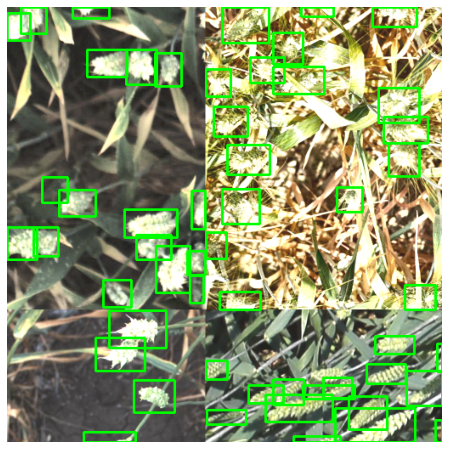

In [29]:
image, target, image_id = train_dataset[1]
print(image_id )
boxes = target['boxes'].cpu().numpy().astype(np.int32)

numpy_image = image.permute(1,2,0).cpu().numpy()

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(numpy_image, (box[1], box[0]), (box[3],  box[2]), (0, 2, 0), 2)
    
ax.set_axis_off()
ax.imshow(numpy_image );

## Fitter

In [30]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [31]:
# from google.colab import output

In [32]:
step=15
if step+1%16:
  print('x')

x


I adjust the train code with apex and gradient accumulation 

In [33]:
device = torch.device('cuda:0')
def collate_fn(batch):
    return tuple(zip(*batch))
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=TrainGlobalConfig.batch_size,
        sampler=RandomSampler(train_dataset),
        pin_memory=False,
        drop_last=True,
        num_workers=TrainGlobalConfig.num_workers,
        collate_fn=collate_fn,
    )
val_loader = torch.utils.data.DataLoader(
        validation_dataset, 
        batch_size=TrainGlobalConfig.batch_size,
        num_workers=TrainGlobalConfig.num_workers,
        shuffle=False,
        sampler=SequentialSampler(validation_dataset),
        pin_memory=False,
        collate_fn=collate_fn,
    )

In [34]:
import warnings

warnings.filterwarnings("ignore")

class Fitter:

    def __init__(self, model, device, config,train_loader):
        self.config = config
        self.epoch = 0

        self.base_dir = f'./{config.folder}'
        if not os.path.exists(self.base_dir):
            os.makedirs(self.base_dir)

        self.log_path = f'{self.base_dir}/log.txt'
        self.best_summary_loss = 10 ** 5
        self.model = model
        self.device = device
        self.mixed_precision = config.mixed_precision
        self.accumulate = config.accumulate
        param_optimizer = list(self.model.named_parameters())
        no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]

        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=config.lr)
        self.model = model.to(device)
        if self.mixed_precision:
            self.model, self.optimizer = amp.initialize(self.model, self.optimizer, opt_level="O1", verbosity=0)

        self.scheduler = config.SchedulerClass(self.optimizer, **config.scheduler_params)
        #torch.optim.lr_scheduler.OneCycleLR( self.optimizer, max_lr=8e-4, pct_start=0.15,
        #                                                     cycle_momentum=False,
        #                                                     steps_per_epoch=len(train_loader), epochs=18)
        #config.SchedulerClass(self.optimizer, **config.scheduler_params)
        #optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-3, steps_per_epoch=len(train_loader), epochs=13,div_factor=7
#                                        ,cycle_momentum=False,pct_start=0.33 )
        self.log(f'Fitter prepared. Device is {self.device}')

    

    def validation(self, val_loader):
        self.model.eval()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(val_loader):
            if self.config.verbose:
                if step % self.config.verbose_step == 0:
                    
                   

                    print(f'Val Step {step}/{len(val_loader)}, ' + \
                            f'summary_loss: {summary_loss.avg:.5f}, ' + \
                            f'time: {(time.time() - t):.5f}', end='\r'  )
                    
                     
            with torch.no_grad():
                images = torch.stack(images)
                images = images.to(self.device).float()
                batch_size = images.shape[0]
                #boxes = [target['boxes'].to(self.device).float() for target in targets]
            #labels = [target['labels'].to(self.device).float() for target in targets] causes forward error
            #print('boxes',boxes.size())
                target_res = {}
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]
                '''
                target_res['bbox'] = boxes
                target_res['cls'] = labels 
                target_res['img_scale'] = torch.tensor([1.0] * batch_size, dtype=torch.float).to(self.device)
                target_res['img_size'] = torch.tensor([images[0].shape[-2:]] * batch_size, dtype=torch.float).to(self.device)
            #loss, _, _ = self.model(images, boxes, labels)
                outputs = self.model(images, target_res)
                loss = outputs['loss']
                '''
                boxes = [target['boxes'].to(self.device).float() for target in targets]
                labels = [target['labels'].to(self.device).float() for target in targets]

                loss, _, _ = self.model(images, boxes, labels)
                summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss

    def train_one_epoch(self, train_loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        for step, (images, targets, image_ids) in enumerate(train_loader):
            #if self.config.verbose:
                #print('x')
            if step % 1 == 0:

              #print(f'summary_loss: {summary_loss.avg:.5f}', end='\r')
              #output.clear('status_text')
              #with output.use_tags('status_text'):

                print(
                                f'Train Step {step}/{len(train_loader)}, ' + \
                                f'summary_loss: {summary_loss.avg:.5f}, ' + \
                                f'time: {(time.time() - t):.5f}', end='\r'
                    )

            images = torch.stack(images)
            images = images.to(self.device).float()
            #print('train',images.size())
            batch_size = images.shape[0]
            #boxes = [target['boxes'].to(self.device).float() for target in targets]
            #labels = [target['labels'].to(self.device).float() for target in targets] causes forward error
            #print('boxes',boxes.size())
            '''
            target_res = {}
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            target_res['bbox'] = boxes
            target_res['cls'] = labels 
            loss, _, _ = self.model(images, boxes, labels)
            outputs = self.model(images, target_res)
            loss = outputs['loss']#/self.accumulate
            '''
            boxes = [target['boxes'].to(self.device).float() for target in targets]
            labels = [target['labels'].to(self.device).float() for target in targets]

            loss, _, _ = self.model(images, boxes, labels)
            # The code from YOLO V5
            if self.mixed_precision:
                with amp.scale_loss(loss, self.optimizer) as scaled_loss:
                    scaled_loss.backward()
            else:
                loss.backward()
            #print('step+1 % self.accumulate',(step+1) % self.accumulate,step,self.accumulate)
             
            if (step+1) % 1 == 0:
              #print('x')
              #for p in (self.model.parameters()):
              #  if p.requires_grad: p.grad.div_(self.accumulate)
              #loss =loss/self.accumulate
              self.optimizer.step()
              self.optimizer.zero_grad()
                
              if self.config.step_scheduler:
                    self.scheduler.step()
              summary_loss.update(loss.detach().item(), batch_size)

        return summary_loss
    def fit(self, train_loader, validation_loader,epochs):
        for e in range(epochs):
            if self.config.verbose:
                lr = self.optimizer.param_groups[0]['lr']
                #lr=self.scheduler.get_lr()[0]
                timestamp = datetime.utcnow().isoformat()
                self.log(f'\n{timestamp}\nLR: {lr}')

            t = time.time()
            summary_loss = self.train_one_epoch(train_loader)

            self.log(
                f'[RESULT]: Train. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            self.save(f'{self.base_dir}/last-checkpoint.bin')

            t = time.time()
            summary_loss = self.validation(validation_loader)

            self.log(
                f'[RESULT]: Val. Epoch: {self.epoch}, summary_loss: {summary_loss.avg:.5f}, time: {(time.time() - t):.5f}')
            if summary_loss.avg < self.best_summary_loss:
                self.best_summary_loss = summary_loss.avg
                self.model.eval()
                self.save(f'{self.base_dir}/best-checkpoint-{str(self.epoch).zfill(3)}epoch.bin')
                for path in sorted(glob(f'{self.base_dir}/best-checkpoint-*epoch.bin'))[:-3]:
                    os.remove(path)

            if self.config.validation_scheduler:
                self.scheduler.step(metrics=summary_loss.avg)

            self.epoch += 1

    def save(self, path):

        self.model.eval()
        torch.save({
            'model_state_dict': self.model.model.state_dict(),
            #'optimizer_state_dict': self.optimizer.state_dict(),
            #'scheduler_state_dict': self.scheduler.state_dict(),
            #'best_summary_loss': self.best_summary_loss,
           # 'epoch': self.epoch,
        }, path)

    def load(self, path=None):
        #checkpoint = torch.load('effdet5-cutmix-augmix'+'/'+path)
        #checkpoint = torch.load('effdet5-cutmix-augmix'+'/'+path)
        
        checkpoint = torch.load('../input/gwd-eff-det-train-like-yolo/model_b4.bin')
        #checkpoint = {k: v for k, v in zip(self.model.model.state_dict().keys(),checkpoint.values())}
        #print(checkpoint)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        #self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        #self.scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        #self.best_summary_loss = checkpoint['best_summary_loss']
        #self.epoch = checkpoint['epoch'] + 1

    def log(self, message):
        if self.config.verbose:
            print(message)
        with open(self.log_path, 'a+') as logger:
            logger.write(f'{message}\n')
print('x')

x


In [35]:
#summary_loss = Fitter(model=net, device=device, config=TrainGlobalConfig,train_loader=train_loader).validation(val_loader)

In [36]:
import gc
torch.cuda.empty_cache()
gc.collect()



40

In [37]:
#net.state_dict().keys()

In [38]:
#!pip install timm
#!pip install effdet
#!pip install  Omegaconf

In [39]:
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
from torch.utils import *

def get_net():
    config = get_efficientdet_config('tf_efficientdet_d4')
    #print(config)
    net = EfficientDet(config, pretrained_backbone=False)
    #print(net.state_dict().keys())
    
    #checkpoint = model_zoo.load_url('https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_d4-5b370b7a.pth')
    #('https://github.com/rwightman/efficientdet-pytorch/releases/download/v0.1/tf_efficientdet_d4-ef44aea8.pth')
    #('../input/efficientdet/efficientdet_d5-ef44aea8.pth') /home/temp/.cache/torch/checkpoints/tf_efficientdet_d5-ef44aea8.pth
    #net.load_state_dict(checkpoint)
    config.num_classes = 1
    config.image_size = 512
    net.class_net = HeadNet(config, num_outputs=config.num_classes, norm_kwargs=dict(eps=.001, momentum=.01))
    return DetBenchTrain(net, config)

net = get_net()

In [40]:
#torch.cuda.set_device(4)


def run_training(train_loader,val_loader,epochs,path=None):
    device = torch.device('cuda:0')
    net.to(device)

    

    fitter = Fitter(model=net, device=device, config=TrainGlobalConfig,train_loader=train_loader)
    #if path is not None:
    fitter.load(path)
    fitter.fit(train_loader, val_loader,epochs=epochs)
print('x')

x


In [41]:
#net
#!nvidia-smi
#summary_loss = Fitter(model=net, device= torch.device('cuda:4'), config=TrainGlobalConfig,train_loader=train_loader).validation(val_loader=val_loader)
'''
lass ExtendDetBenchTrain(DetBenchTrain):

def __init__(self, model, config):
    super(ExtendDetBenchTrain, self).__init__(model, config)

def forward(self, x, target):
    class_out, box_out = self.model(x)
    cls_targets, box_targets, num_positives = self.anchor_labeler.batch_label_anchors(
        x.shape[0], target['bbox'], target['cls'])
    loss, class_loss, box_loss = self.loss_fn(class_out, box_out, cls_targets, box_targets,      num_positives)
    output = dict(loss=loss, class_loss=class_loss, box_loss=box_loss)
   return output
'''
 

"\nlass ExtendDetBenchTrain(DetBenchTrain):\n\ndef __init__(self, model, config):\n    super(ExtendDetBenchTrain, self).__init__(model, config)\n\ndef forward(self, x, target):\n    class_out, box_out = self.model(x)\n    cls_targets, box_targets, num_positives = self.anchor_labeler.batch_label_anchors(\n        x.shape[0], target['bbox'], target['cls'])\n    loss, class_loss, box_loss = self.loss_fn(class_out, box_out, cls_targets, box_targets,      num_positives)\n    output = dict(loss=loss, class_loss=class_loss, box_loss=box_loss)\n   return output\n"

In [42]:
#model.load_state_dict(torch.load('/kaggle/working/model_best.pth'))
run_training(train_loader, val_loader,10,path='../input/gwd-eff-det-train-like-yolo/model_b4.bin' )

Fitter prepared. Device is cuda:0

2020-08-01T11:54:08.950779
LR: 0.0002
[RESULT]: Train. Epoch: 0, summary_loss: 0.44529, time: 620.47580
[RESULT]: Val. Epoch: 0, summary_loss: 0.42242, time: 101.26175

2020-08-01T12:06:11.061340
LR: 0.0002
[RESULT]: Train. Epoch: 1, summary_loss: 0.41642, time: 612.05060
[RESULT]: Val. Epoch: 1, summary_loss: 0.40020, time: 98.31032

2020-08-01T12:18:01.865425
LR: 0.0002
[RESULT]: Train. Epoch: 2, summary_loss: 0.40077, time: 617.05361
[RESULT]: Val. Epoch: 2, summary_loss: 0.38863, time: 101.86665

2020-08-01T12:30:01.225227
LR: 0.0002
[RESULT]: Train. Epoch: 3, summary_loss: 0.39209, time: 614.36978
[RESULT]: Val. Epoch: 3, summary_loss: 0.37865, time: 99.63769

2020-08-01T12:41:55.681833
LR: 0.0002
[RESULT]: Train. Epoch: 4, summary_loss: 0.38349, time: 613.57890
[RESULT]: Val. Epoch: 4, summary_loss: 0.37921, time: 99.83444

2020-08-01T12:53:49.352964
LR: 0.0002
[RESULT]: Train. Epoch: 5, summary_loss: 0.38040, time: 605.72737
[RESULT]: Val. Epoc

In [43]:
#run_training(train_loader, val_loader,17,'best-checkpoint-024epoch')


In [44]:
#run_training()
torch.save({
            'model_state_dict': net.state_dict()},'/kaggle/working/model_b4_stich_mix.bin'
             
)

### Thank you for reading my kernel!

# If it is helpful to you ,upvote it please :D